# Download the MNIST Dataset

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to range [-1, 1]
])

# Download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset size: 60000
Test dataset size: 10000


# Split the Dataset for Multiple Clients

In [3]:
from torch.utils.data import random_split

num_clients = 5

# Split the training dataset into `num_clients` parts
client_datasets = random_split(train_dataset, [len(train_dataset) // num_clients] * num_clients)

# Check the size of each client's dataset
for i, client_data in enumerate(client_datasets):
    print(f"Client {i+1} dataset size: {len(client_data)}")


Client 1 dataset size: 12000
Client 2 dataset size: 12000
Client 3 dataset size: 12000
Client 4 dataset size: 12000
Client 5 dataset size: 12000


# Visualize the Data

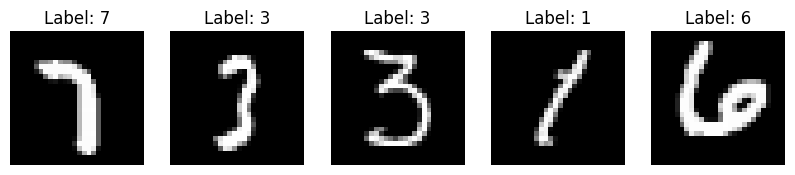

In [4]:
import matplotlib.pyplot as plt

def visualize_data(dataset):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Visualize data from the first client's dataset
visualize_data(client_datasets[0])


# Defining the Model

In [5]:
import torch.nn as nn

# Defining a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(28 * 28, 128),  # Input layer
            nn.ReLU(),               # Activation function
            nn.Linear(128, 10)       # Output layer (10 classes)
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input image
        return self.fc(x)

# Initializing the model
global_model = SimpleNN()
print(global_model)


SimpleNN(
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


#  Local Training Function

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Local training function
def train_local_model(model, data, epochs=2, batch_size=32, lr=0.01):
    model.train()
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights


# Global Aggregation Function

In [7]:
def average_weights(client_models):
    global_model = client_models[0]
    global_state_dict = global_model.state_dict()

    # Average weights from all client models
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack([client_model.state_dict()[key] for client_model in client_models], dim=0).mean(dim=0)

    global_model.load_state_dict(global_state_dict)
    return global_model


# Federated Averaging Loop

In [ ]:
# Federated learning loop
num_rounds = 5
local_epochs = 2

for round in range(num_rounds):
    print(f"--- Round {round+1} ---")
    client_models = []

    for client_data in client_datasets:
        # Clone the global model for local training
        local_model = SimpleNN()
        local_model.load_state_dict(global_model.state_dict())

        # Train locally
        train_local_model(local_model, client_data, epochs=local_epochs)
        client_models.append(local_model)

    # Aggregate local models to update the global model
    global_model = average_weights(client_models)

print("Federated learning completed!")


--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
Federated learning completed!


# Evaluating the Global Model

In [8]:
from torch.utils.data import DataLoader

def evaluate_model(model, test_data):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

    return accuracy



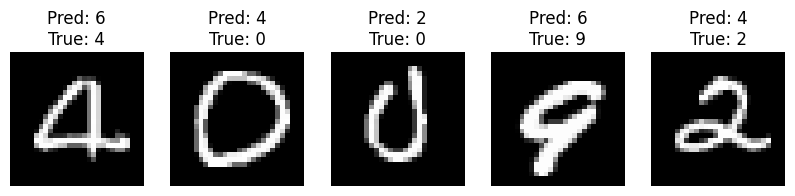

In [9]:
def visualize_predictions(model, test_data):
    model.eval()
    test_loader = DataLoader(test_data, batch_size=5, shuffle=True)
    inputs, labels = next(iter(test_loader))

    with torch.no_grad():
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(inputs[i].squeeze(), cmap='gray')
        ax.set_title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}")
        ax.axis('off')
    plt.show()

# Visualize predictions
visualize_predictions(global_model, test_dataset)


# Trying out different variations in distributed setting

(a) Client Participation:Currently, all clients might be participating in each round. Trying to reduce client participation per round (e.g., select a random subset of clients for training in each round).

In [ ]:
import random

def select_clients(client_datasets, fraction=0.5):
    num_selected = int(len(client_datasets) * fraction)
    return random.sample(client_datasets, num_selected)

# Example: Select 50% of clients for a round
selected_clients = select_clients(client_datasets, fraction=0.5)


(b) Increasing the model complexity

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Flatten after 2x2 pooling
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        return self.fc2(x)


In [ ]:
global_model = CNN()  # Initialize the global model with the new architecture

In [ ]:
local_model = CNN()  # Use the new CNN model for local training

In [ ]:
for round in range(num_rounds):
    print(f"--- Round {round+1} ---")

    # Selecting a fraction of clients to participate
    selected_clients = select_clients(client_datasets, fraction=0.5)
    client_models = []

    for client_data in selected_clients:
        # Clone the global model for local training
        local_model = CNN()
        local_model.load_state_dict(global_model.state_dict())

        # Train locally
        train_local_model(local_model, client_data, epochs=local_epochs)
        client_models.append(local_model)

    # Aggregating local models to update the global model
    global_model = average_weights(client_models)

    # Evaluating global model after the round
    accuracy = evaluate_model(global_model, test_dataset)  # Accuracy is now returned
    accuracies.append(accuracy)
    print(f"Round {round+1} Accuracy: {accuracy:.2f}%")

print("Federated learning completed!")


--- Round 1 ---
Round 1 Accuracy: 95.15%
--- Round 2 ---
Round 2 Accuracy: 96.21%
--- Round 3 ---
Round 3 Accuracy: 97.21%
--- Round 4 ---
Round 4 Accuracy: 97.71%
--- Round 5 ---
Round 5 Accuracy: 97.73%
Federated learning completed!


# Experimenting with different client participations

In [ ]:
# Different participation levels to experiment with
participation_levels = [0.25, 0.5, 0.75, 1.0]
results = {}

for fraction in participation_levels:
    print(f"\n=== Experiment with {int(fraction * 100)}% Client Participation ===")
    accuracies = []  # Reset accuracies for this participation level

    for round in range(num_rounds):
        print(f"--- Round {round+1} ---")

        selected_clients = select_clients(client_datasets, fraction=fraction)
        client_models = []

        for client_data in selected_clients:
            # Clone the global model for local training
            local_model = CNN()
            local_model.load_state_dict(global_model.state_dict())

            # Train locally
            train_local_model(local_model, client_data, epochs=local_epochs)
            client_models.append(local_model)

        # Aggregating local models to update the global model
        global_model = average_weights(client_models)

        # Evaluating global model after the round
        accuracy = evaluate_model(global_model, test_dataset)  # Accuracy is now returned
        accuracies.append(accuracy)
        print(f"Round {round+1} Accuracy: {accuracy:.2f}%")

    # Store results for this participation level
    results[int(fraction * 100)] = accuracies
    print(f"Completed experiment for {int(fraction * 100)}% client participation.")

for level, acc in results.items():
    print(f"\nClient Participation: {level}%")
    print(f"Accuracies over rounds: {acc}")



=== Experiment with 25% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 97.98%
--- Round 2 ---
Round 2 Accuracy: 98.18%
--- Round 3 ---
Round 3 Accuracy: 98.03%
--- Round 4 ---
Round 4 Accuracy: 98.33%
--- Round 5 ---
Round 5 Accuracy: 98.47%
Completed experiment for 25% client participation.

=== Experiment with 50% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 98.60%
--- Round 2 ---
Round 2 Accuracy: 98.59%
--- Round 3 ---
Round 3 Accuracy: 98.55%
--- Round 4 ---
Round 4 Accuracy: 98.79%
--- Round 5 ---
Round 5 Accuracy: 98.74%
Completed experiment for 50% client participation.

=== Experiment with 75% Client Participation ===
--- Round 1 ---
Round 1 Accuracy: 98.75%
--- Round 2 ---
Round 2 Accuracy: 98.71%
--- Round 3 ---
Round 3 Accuracy: 98.77%
--- Round 4 ---
Round 4 Accuracy: 98.84%
--- Round 5 ---
Round 5 Accuracy: 98.89%
Completed experiment for 75% client participation.

=== Experiment with 100% Client Participation ===
--- Round 1 ---
Round 1 Accurac

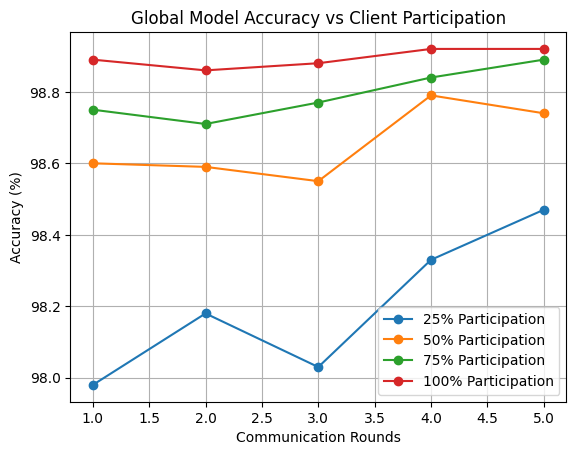

In [ ]:
# Plot accuracy trends
import matplotlib.pyplot as plt

for level, acc in results.items():
    rounds = list(range(1, num_rounds + 1))
    plt.plot(rounds, acc, marker='o', label=f"{level}% Participation")

plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.title('Global Model Accuracy vs Client Participation')
plt.legend()
plt.grid()
plt.show()


# Metrics Tracking and Visualization

In [ ]:
communication_rounds = []
global_accuracies = []
losses = []

def track_metrics(round, accuracy, loss):
    communication_rounds.append(round)
    global_accuracies.append(accuracy)
    losses.append(loss)


In [ ]:
def plot_metrics():
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))

    # Plot Accuracy vs Rounds
    plt.subplot(1, 2, 1)
    plt.plot(communication_rounds, global_accuracies, marker='o')
    plt.title('Rounds vs. Accuracy')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(communication_rounds, losses, marker='x', color='red')
    plt.title('Rounds vs. Loss')
    plt.xlabel('Communication Rounds')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
# Updated federated learning loop
num_rounds = 5
local_epochs = 2

for round in range(num_rounds):
    print(f"--- Round {round+1} ---")
    client_models = []

    for client_data in client_datasets:
        # Clone the global model for local training
        local_model = SimpleNN()
        local_model.load_state_dict(global_model.state_dict())

        # Train locally
        train_local_model(local_model, client_data, epochs=local_epochs)
        client_models.append(local_model)

    # Aggregate local models to update the global model
    global_model = average_weights(client_models)

    # Evaluate the global model after aggregation
    accuracy = evaluate_model(global_model, test_dataset)
    loss = None
    track_metrics(round + 1, accuracy, loss)




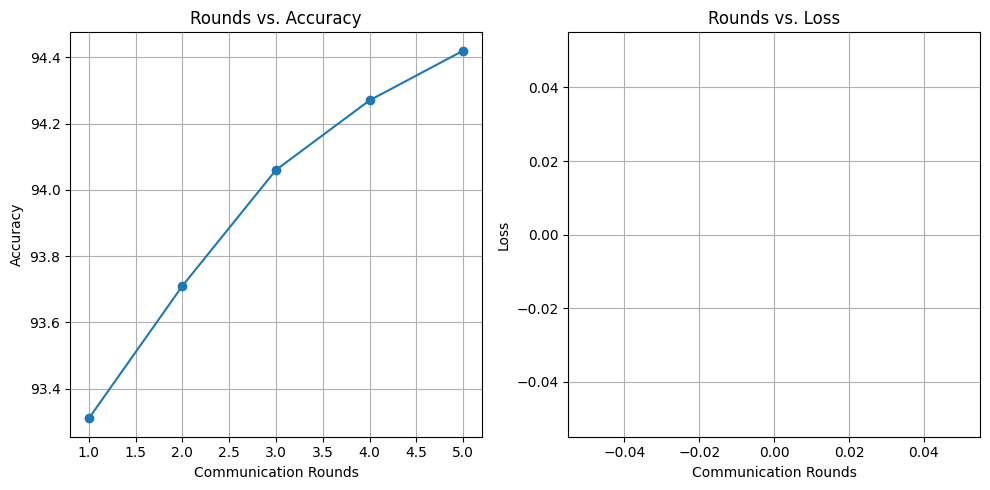

In [ ]:
# Plot metrics after training
plot_metrics()

In [ ]:
def federated_train(global_model, local_epochs):
    accuracies = []
    losses = []

    for round in range(num_rounds):
        print(f"--- Round {round+1} ---")
        client_models = []

        for client_data in client_datasets:
            # Clone the global model for local training
            local_model = SimpleNN()
            local_model.load_state_dict(global_model.state_dict())

            # Train locally with specified local epochs
            train_local_model(local_model, client_data, epochs=local_epochs)
            client_models.append(local_model)

        # Aggregate local models to update the global model
        global_model = average_weights(client_models)

        # Evaluate global model after aggregation
        accuracy = evaluate_model(global_model, test_dataset)
        loss = None  # Replace this with actual loss computation if available
        accuracies.append(accuracy)
        losses.append(loss)

    return accuracies, losses


# Experimenting with Local Epochs

Training with 1 local epochs...
--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
Training with 5 local epochs...
--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---
Training with 10 local epochs...
--- Round 1 ---
--- Round 2 ---
--- Round 3 ---
--- Round 4 ---
--- Round 5 ---


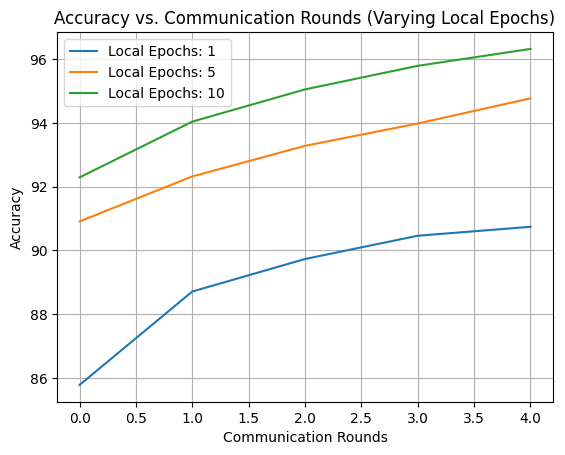

In [ ]:
local_epochs_list = [1, 5, 10]

results = {}

# Loop through different local epochs
for local_epochs in local_epochs_list:
    print(f"Training with {local_epochs} local epochs...")
    global_model = SimpleNN()  # Initialize a new global model for this experiment
    accuracies, losses = federated_train(global_model=global_model, local_epochs=local_epochs)
    results[local_epochs] = (accuracies, losses)


# Plot results for comparison
for local_epochs, (accuracies, losses) in results.items():
    plt.plot(range(len(accuracies)), accuracies, label=f'Local Epochs: {local_epochs}')

plt.title('Accuracy vs. Communication Rounds (Varying Local Epochs)')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


As we can see, the graph depicts the impact of varying local epochs (1, 5, and 10) on the accuracy of the global model across communication rounds in a Federated Learning setting. As expected, models trained with higher local epochs achieve higher accuracy faster due to more substantial local updates before global aggregation.

* With 1 local epoch, the global model shows steady but slower improvement in accuracy, reflecting minimal local training per client before aggregation.
* With 5 local epochs, the model converges more quickly, achieving higher accuracy after fewer communication rounds.
* With 10 local epochs, the model demonstrates the fastest convergence and highest accuracy across all rounds, indicating that extensive local training improves the global model's performance.

However, increasing local epochs comes at the cost of more computation per client, and the trade-off between communication efficiency and computational load should be considered in real-world applications.

# Creating Skewed Non-IID Distributions

In [10]:
from torch.utils.data import Subset
import numpy as np

def create_non_iid_datasets(dataset, num_clients):
    indices = [[] for _ in range(num_clients)]
    labels = np.array([dataset[i][1] for i in range(len(dataset))])

    for i in range(num_clients):
        # Each client gets 2 specific digits (e.g., client 0: [0,1], client 1: [2,3], ...)
        digit_range = list(range(2 * i, 2 * i + 2))
        client_indices = np.where(np.isin(labels, digit_range))[0]
        indices[i] = client_indices

    # Creating Subset datasets for each client
    client_datasets = [Subset(dataset, idx) for idx in indices]
    return client_datasets

# Creating Non-IID datasets
non_iid_client_datasets = create_non_iid_datasets(train_dataset, num_clients)

# Checking distribution of one client
print(f"Client 0 labels: {[train_dataset[i][1] for i in non_iid_client_datasets[0].indices][:10]}")


Client 0 labels: [0, 1, 1, 1, 1, 0, 1, 1, 0, 0]


# Training FedAvg on Non-IID Data

In [13]:
# Train Federated Learning on Non-IID data
global_model_non_iid = SimpleNN()
accuracies_non_iid = []

for round in range(5):
    print(f"--- Round {round+1} (Non-IID) ---")
    client_models = []

    for client_data in non_iid_client_datasets:
        local_model = SimpleNN()
        local_model.load_state_dict(global_model_non_iid.state_dict())
        train_local_model(local_model, client_data, epochs=5)
        client_models.append(local_model)

    # Aggregate models
    global_model_non_iid = average_weights(client_models)

    # Evaluate
    accuracy = evaluate_model(global_model_non_iid, test_dataset)
    accuracies_non_iid.append(accuracy)
    print(f"Round {round+1} Accuracy (Non-IID): {accuracy:.2f}%")


--- Round 1 (Non-IID) ---
Round 1 Accuracy (Non-IID): 24.22%
--- Round 2 (Non-IID) ---
Round 2 Accuracy (Non-IID): 58.41%
--- Round 3 (Non-IID) ---
Round 3 Accuracy (Non-IID): 64.24%
--- Round 4 (Non-IID) ---
Round 4 Accuracy (Non-IID): 65.81%
--- Round 5 (Non-IID) ---
Round 5 Accuracy (Non-IID): 66.82%


# Training FedAvg on IID Data

In [14]:
# Train Federated Learning on IID data
global_model_iid = SimpleNN()
accuracies_iid = []

for round in range(5):
    print(f"--- Round {round+1} (IID) ---")
    client_models = []

    for client_data in client_datasets:  # Original IID splits
        local_model = SimpleNN()
        local_model.load_state_dict(global_model_iid.state_dict())
        train_local_model(local_model, client_data, epochs=5)
        client_models.append(local_model)

    # Aggregate models
    global_model_iid = average_weights(client_models)

    # Evaluate
    accuracy = evaluate_model(global_model_iid, test_dataset)
    accuracies_iid.append(accuracy)
    print(f"Round {round+1} Accuracy (IID): {accuracy:.2f}%")


--- Round 1 (IID) ---
Round 1 Accuracy (IID): 90.95%
--- Round 2 (IID) ---
Round 2 Accuracy (IID): 92.28%
--- Round 3 (IID) ---
Round 3 Accuracy (IID): 93.20%
--- Round 4 (IID) ---
Round 4 Accuracy (IID): 94.13%
--- Round 5 (IID) ---
Round 5 Accuracy (IID): 94.61%


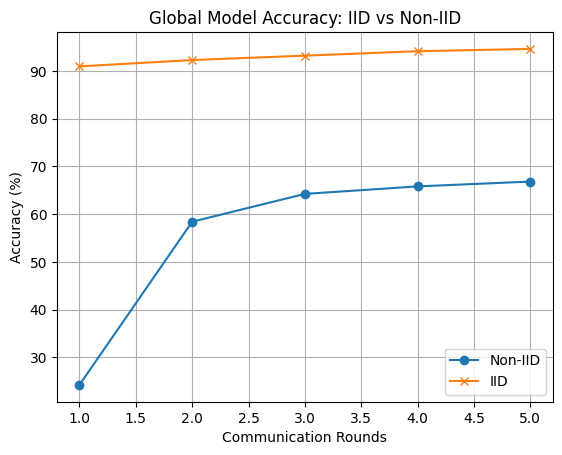

In [16]:
# Plot accuracy comparison
rounds = list(range(1, 5 + 1))

plt.plot(rounds, accuracies_non_iid, label='Non-IID', marker='o')
plt.plot(rounds, accuracies_iid, label='IID', marker='x')
plt.title('Global Model Accuracy: IID vs Non-IID')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()


### Observations from the Plot

1. **Performance Gap Between IID and Non-IID:**
   - The model trained on **IID data** achieves higher accuracy (above 90%) across all communication rounds.
   - The **Non-IID model** starts with lower accuracy (~30%) and improves more slowly, reaching about 65% by the 5th round.

2. **IID Data Characteristics:**
   - In the IID setting, each client's data reflects the overall distribution of the dataset, leading to faster convergence and better generalization.

3. **Non-IID Data Characteristics:**
   - In the Non-IID setting, data distribution differs significantly across clients, causing conflicts in model updates during aggregation. This slows down convergence and reduces overall accuracy.

4. **Convergence Trend:**
   - The IID model stabilizes around 90% accuracy after the first round.
   - The Non-IID model shows steady but slower improvement, highlighting the challenges of learning from skewed client data.

5. **Real-World Implications:**
   - Federated Learning in real-world applications (e.g., user devices) often involves Non-IID data. This experiment shows the need for strategies to handle such scenarios effectively.

6. **Trade-Offs:**
   - IID data provides an ideal benchmark but is less reflective of real-world conditions.
   - Non-IID experiments help evaluate the robustness of Federated Learning systems in practical settings.

---

### Key Takeaways

- **Main Challenge:** Non-IID data makes it harder for the global model to generalize effectively.
- **Possible Solutions:**
  - Explore techniques like data augmentation, advanced aggregation methods (e.g., FedProx), or personalized models.
- **Conclusion:** Addressing Non-IID challenges is critical to improving the performance and applicability of Federated Learning in real-world scenarios.
